In [24]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import albumentations as A

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0 # Added EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm # Useful for progress bars, especially if you add custom loops


In [26]:
# --- 1. Data Download and Extraction ---
def download_and_extract_dataset(url, zip_name, extract_folder_name):
    """
    Downloads a zip file from a URL and extracts its contents.
    Skips download/extraction if the target directory already exists.

    Args:
        url (str): The URL of the zip file.
        zip_name (str): The name to save the zip file as.
        extract_folder_name (str): The name of the folder where content will be extracted.

    Returns:
        str: The path to the extracted dataset directory.
    """
    zip_path = tf.keras.utils.get_file(
        zip_name,
        origin=url,
        extract=False # We'll extract manually to control path
    )

    extract_dir = os.path.join(os.path.dirname(zip_path), extract_folder_name)

    if not os.path.exists(extract_dir) or not os.listdir(extract_dir):
        print(f"Extracting {zip_name} to {extract_dir}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(os.path.dirname(zip_path))
        print("✅ Dataset extracted successfully")
    else:
        print(f"Dataset already found and appears extracted at {extract_dir}")

    return extract_dir

# Perform data operations
base_dataset_dir = download_and_extract_dataset(
    cfg.DATASET_URL, cfg.DATASET_ZIP_NAME, cfg.EXTRACT_FOLDER_NAME
)
train_dir = os.path.join(base_dataset_dir, "train")
val_dir = os.path.join(base_dataset_dir, "validation")

print(f"Train directory: {train_dir} (contents: {os.listdir(train_dir)})")
print(f"Validation directory: {val_dir} (contents: {os.listdir(val_dir)})")

Dataset already found and appears extracted at /root/.keras/datasets/cats_and_dogs_filtered
Train directory: /root/.keras/datasets/cats_and_dogs_filtered/train (contents: ['cats', 'dogs'])
Validation directory: /root/.keras/datasets/cats_and_dogs_filtered/validation (contents: ['cats', 'dogs'])


In [27]:
# --- 2. Albumentations Transforms Definition ---
# Using ImageNet normalization means values will be approximately -2 to +2
# This generally good for pre-trained models.
train_transform = A.Compose([
    A.RandomResizedCrop(size=(cfg.IMG_SIZE, cfg.IMG_SIZE), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Affine(
        scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
        translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
        rotate=(-20, 20),
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_REFLECT_101,
        p=0.5
    ),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

val_transform = A.Compose([
    A.Resize(height=cfg.IMG_SIZE, width=cfg.IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [34]:
# --- 3. TensorFlow Dataset Creation with Albumentations Integration ---
def get_image_paths_and_labels(data_dir):
    """
    Scans a directory (assuming structure: data_dir/class_name/images.jpg)
    to collect image file paths and their corresponding integer labels.

    Args:
        data_dir (str): The path to the dataset directory (e.g., 'train', 'validation').

    Returns:
        tuple: (numpy.ndarray of image paths, numpy.ndarray of labels, list of class names)
    """
    image_paths = []
    labels = []
    # Perform directory listing outside of any function that might be traced by TensorFlow
    class_names = sorted(os.listdir(data_dir)) # Ensures consistent mapping (0, 1, ...)

    if not class_names:
        raise ValueError(f"No classes found in directory: {data_dir}. Check dataset structure.")

    print(f"Classes found in {data_dir}: {class_names}")

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            print(f"Warning: Skipping non-directory item in {data_dir}: {class_name}")
            continue
        # Perform file listing outside of any function that might be traced by TensorFlow
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_paths.append(file_path)
                labels.append(label)

    if not image_paths:
        raise ValueError(f"No image files found in {data_dir}. Check file extensions and directory structure.")

    return np.array(image_paths), np.array(labels, dtype=np.int64), class_names

# Get paths and labels for training and validation datasets
train_paths, train_labels, class_names = get_image_paths_and_labels(train_dir)
val_paths, val_labels, _ = get_image_paths_and_labels(val_dir) # Use _ as class_names are same

print(f"Total training images: {len(train_paths)}")
print(f"Total validation images: {len(val_paths)}")
print(f"Detected class names: {class_names}")


def apply_albumentations_to_tf_image(image_path, label, transform):
    """
    Loads an image from path, applies Albumentations transform using tf.py_function,
    and returns the processed image and label. This function is designed to be
    mapped over a tf.data.Dataset.

    Args:
        image_path (tf.Tensor): A TensorFlow string tensor representing the image file path.
        label (tf.Tensor): A TensorFlow integer tensor representing the image label.
        transform (albumentations.Compose): The Albumentations composition to apply.

    Returns:
        tuple: (tf.Tensor with processed image, tf.Tensor with label)
    """
    def _process_image_np(image_path_tensor, label_np):
        # Decode image path bytes to string for OpenCV
        image_path_str = image_path_tensor.numpy().decode("utf-8")

        # Read image with OpenCV (BGR format by default)
        image = cv2.imread(image_path_str)

        # --- Robust Error Handling for Image Loading ---
        if image is None:
            # Log the error and return a black dummy image.
            # This prevents the tf.function ValueError by ensuring consistent output shapes.
            print(f"Error: Could not read image {image_path_str}. Returning a black dummy image.")
            # Ensure the dummy image matches the expected shape and dtype
            return np.zeros((cfg.IMG_SIZE, cfg.IMG_SIZE, 3), dtype=np.float32), label_np

        # Convert BGR (OpenCV default) to RGB (common for deep learning models)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply Albumentations transform
        augmented = transform(image=image)
        image = augmented["image"]

        # Ensure image is float32 for model input
        image = image.astype(np.float32)
        return image, label_np

    # Wrap the NumPy/OpenCV/Albumentations operations in tf.py_function
    # Tout specifies the output types of the Python function; must match precisely.
    image, label = tf.py_function(
        func=_process_image_np,
        inp=[image_path, label],
        Tout=(tf.float32, tf.int64) # Image (float32) and Label (int64)
    )

    # CRITICAL: Set the static shapes as tf.py_function loses this information.
    # This enables TensorFlow to build the graph correctly for batching and model input.
    image.set_shape([cfg.IMG_SIZE, cfg.IMG_SIZE, 3])
    label.set_shape([]) # Scalar label (no dimensions)

    return image, label

# Create TensorFlow Datasets
# Use `tf.data.AUTOTUNE` to let TensorFlow determine optimal parallel processing
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(train_paths), seed=cfg.SEED) # Shuffle with full buffer
train_ds = train_ds.map(lambda x, y: apply_albumentations_to_tf_image(x, y, train_transform),
                        num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(cfg.BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # Prefetch for pipeline efficiency

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(lambda x, y: apply_albumentations_to_tf_image(x, y, val_transform),
                      num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(cfg.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Classes found in /root/.keras/datasets/cats_and_dogs_filtered/train: ['cats', 'dogs']
Classes found in /root/.keras/datasets/cats_and_dogs_filtered/validation: ['cats', 'dogs']
Total training images: 2000
Total validation images: 1000
Detected class names: ['cats', 'dogs']



Displaying 9 sample images from the processed training dataset:


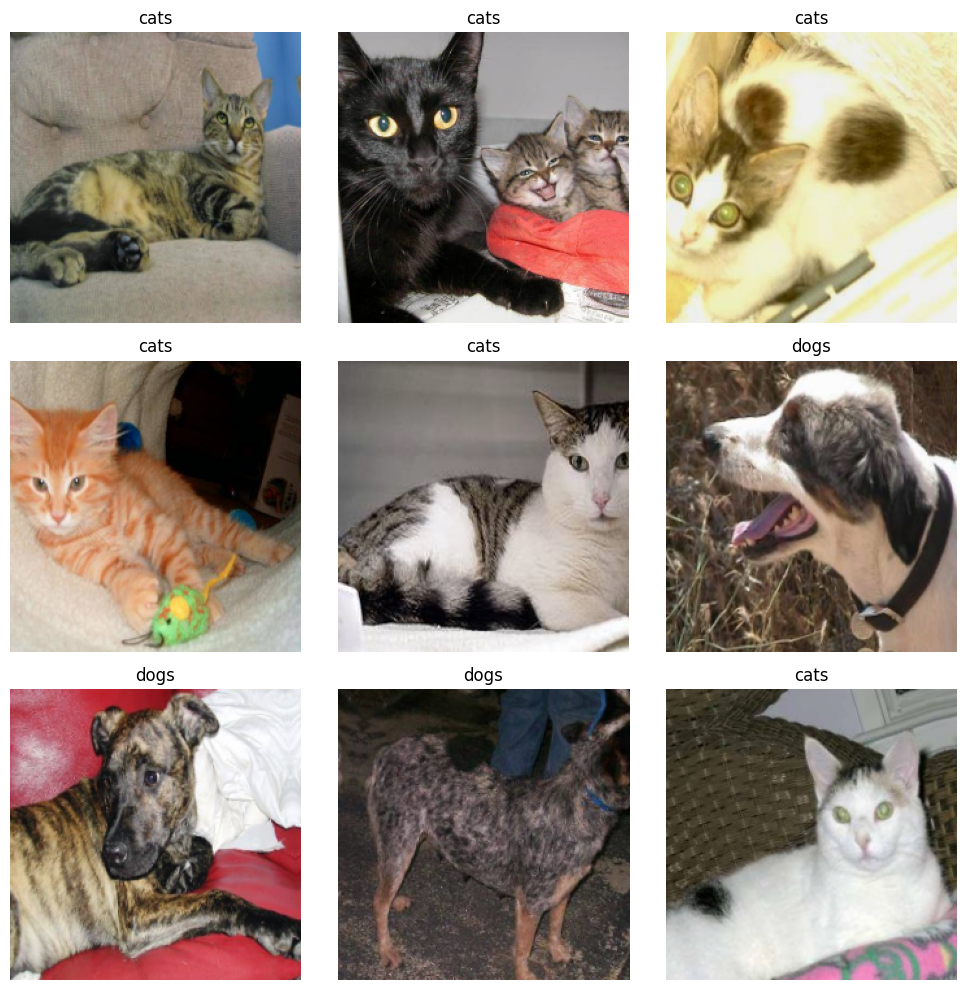

In [35]:
# --- 4. Visualize Sample Images from Processed Dataset ---
print("\nDisplaying 9 sample images from the processed training dataset:")
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(min(9, cfg.BATCH_SIZE)):
        ax = plt.subplot(3, 3, i + 1)

        img_display = images[i].numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_display = (img_display * std + mean)
        img_display = np.clip(img_display, 0, 1) * 255

        plt.imshow(img_display.astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [36]:
# --- 5. Model Definition ---
def create_transfer_learning_model(input_shape, num_classes, base_model_name, dropout_rate=0.3):
    """
    Creates a Keras model for transfer learning.

    Args:
        input_shape (tuple): Shape of the input images (height, width, channels).
        num_classes (int): Number of output classes.
        base_model_name (str): Name of the pre-trained model to use (e.g., "MobileNetV2", "EfficientNetB0").
        dropout_rate (float): Dropout rate for the classification head.

    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    if base_model_name == "MobileNetV2":
        base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    elif base_model_name == "EfficientNetB0":
        base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
    else:
        raise ValueError(f"Unsupported base_model_name: {base_model_name}")

    # Initially freeze the base model layers for feature extraction
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False) # Important: set training=False when base_model.trainable is False
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model, base_model # Return base_model separately for fine-tuning

# Create the model
num_classes = len(class_names)
model, base_model = create_transfer_learning_model(
    input_shape=(cfg.IMG_SIZE, cfg.IMG_SIZE, 3),
    num_classes=num_classes,
    base_model_name=cfg.BASE_MODEL_NAME,
    dropout_rate=cfg.DROPOUT_RATE
)

# Compile the model for feature extraction stage
model.compile(
    optimizer=Adam(learning_rate=cfg.LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Model Summary (Feature Extraction Stage) ---")
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Model Summary (Feature Extraction Stage) ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [37]:
# --- 6. Callbacks for Training Optimization ---
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=cfg.EARLY_STOPPING_PATIENCE,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=cfg.REDUCE_LR_PATIENCE,
    min_lr=cfg.MIN_LR,
    verbose=1
)

In [39]:
# --- 7. Model Training (Two Stages) ---

# Stage 1: Feature Extraction (Train only the classification head)
print("\n--- Stage 1: Training Classification Head (Feature Extraction) ---")
print(f"Initial Learning Rate: {cfg.LEARNING_RATE}")

history_feature_extraction = None # Initialize to None
try:
    history_feature_extraction = model.fit(
        train_ds,
        epochs=cfg.EPOCHS_FEATURE_EXTRACTION,
        validation_data=val_ds,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    print("\nStage 1 (Feature Extraction) complete.")
except Exception as e:
    print(f"\nAn error occurred during Stage 1 training: {e}")

# Stage 2: Fine-tuning (Unfreeze base model and train with a very low learning rate)
print("\n--- Stage 2: Fine-tuning Base Model and Classification Head ---")

# Unfreeze the base model
base_model.trainable = True

# It's good practice to recompile the model after changing trainable status
# and use a much lower learning rate for fine-tuning.
model.compile(
    optimizer=Adam(learning_rate=cfg.FINE_TUNE_LEARNING_RATE), # Very low LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Fine-tune Learning Rate: {cfg.FINE_TUNE_LEARNING_RATE}")
print("\n--- Model Summary (Fine-tuning Stage) ---")
model.summary() # Check to ensure all layers are now trainable

# Reset callbacks for fine-tuning, or use adjusted patience if desired
# For simplicity, using the same callbacks here.
history_fine_tune = None # Initialize to None
initial_epoch_fine_tune = 0
if history_feature_extraction:
    initial_epoch_fine_tune = history_feature_extraction.epoch[-1] + 1

try:
    history_fine_tune = model.fit(
        train_ds,
        epochs=cfg.EPOCHS_FINE_TUNE,
        validation_data=val_ds,
        callbacks=[early_stopping, reduce_lr], # Use the same callbacks or define new ones
        initial_epoch=initial_epoch_fine_tune, # Start from where previous training left off
        verbose=1
    )
    print("\nStage 2 (Fine-tuning) complete.")
except Exception as e:
    print(f"\nAn error occurred during Stage 2 training: {e}")

# Combine histories for plotting
combined_history = {}
if history_feature_extraction and history_fine_tune:
    for key in history_feature_extraction.history.keys():
        if key in history_fine_tune.history.keys():
            combined_history[key] = history_feature_extraction.history[key] + history_fine_tune.history[key]
        else:
            # If a key is only in feature extraction history, just use that
            combined_history[key] = history_feature_extraction.history[key]
    # Add keys that are only in fine-tune history
    for key in history_fine_tune.history.keys():
        if key not in combined_history:
             combined_history[key] = history_fine_tune.history[key]
elif history_feature_extraction:
    combined_history = history_feature_extraction.history
elif history_fine_tune:
     combined_history = history_fine_tune.history
else:
    print("Warning: No training history available to combine.")


--- Stage 1: Training Classification Head (Feature Extraction) ---
Initial Learning Rate: 0.001
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.5810 - loss: 0.6893 - val_accuracy: 0.5050 - val_loss: 1.0067 - learning_rate: 1.0000e-05
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 270ms/step - accuracy: 0.8045 - loss: 0.4569 - val_accuracy: 0.4380 - val_loss: 0.8825 - learning_rate: 1.0000e-05
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.8713 - loss: 0.3626 - val_accuracy: 0.4860 - val_loss: 0.8503 - learning_rate: 1.0000e-05
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 291ms/step - accuracy: 0.8941 - loss: 0.2899 - val_accuracy: 0.5010 - val_loss: 0.7631 - learning_rate: 1.0000e-05
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 290ms/step - accuracy: 0.9083 - loss: 0.2379 - val_accuracy: 0.5670 - val_loss: 0.6914 - learning_rate: 1.0000e-05
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 259ms/step - accuracy: 0.9177 - loss: 0.2170 - val_accuracy: 0.6170 - val_loss

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 4,010,110 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)


Stage 2 (Fine-tuning) complete.



Evaluating final model on validation set...
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 205ms/step - accuracy: 0.9722 - loss: 0.1087
Final Validation Loss: 0.1407
Final Validation Accuracy: 0.9500

Generating predictions for classification report and confusion matrix...
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 297ms/step

Classification Report:
              precision    recall  f1-score   support

        cats       0.92      0.99      0.95       500
        dogs       0.99      0.91      0.95       500

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000


Confusion Matrix:


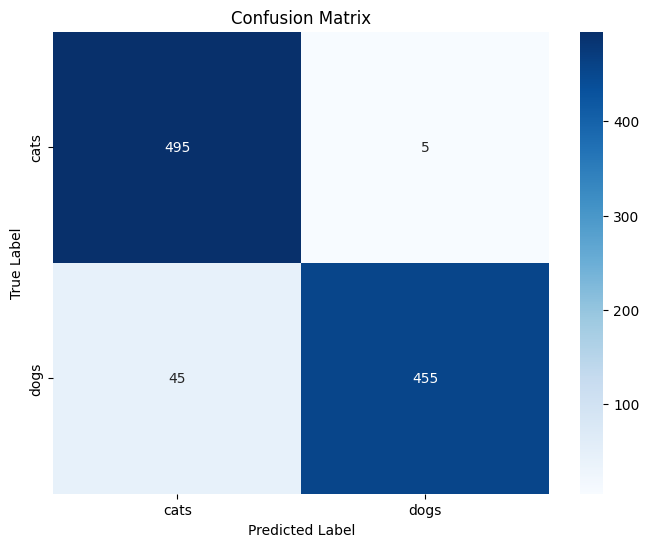

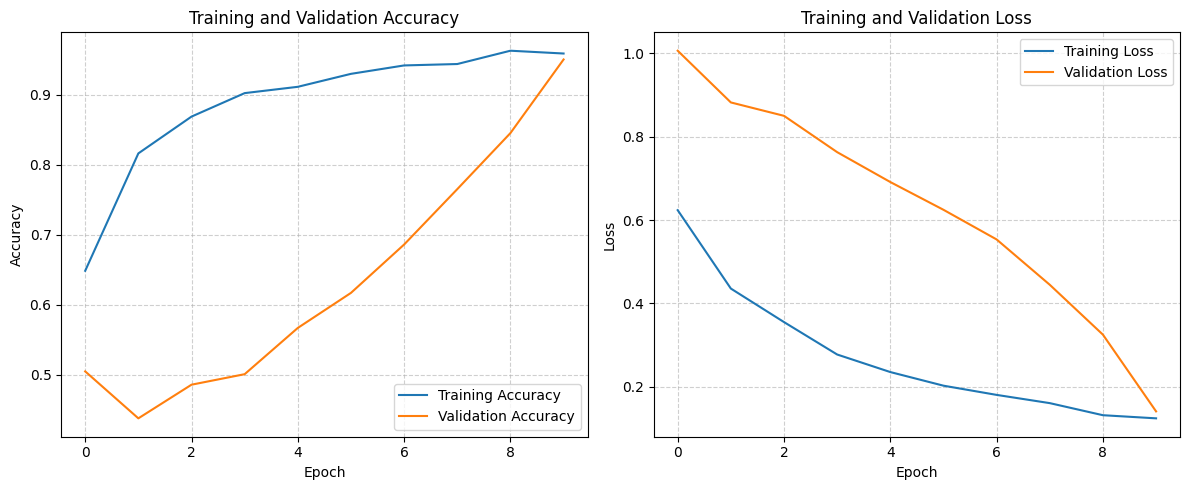

In [40]:
# --- 8. Model Evaluation and Visualization ---
print("\nEvaluating final model on validation set...")
val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

print("\nGenerating predictions for classification report and confusion matrix...")
y_true = []
for _, labels in val_ds.unbatch():
    y_true.append(labels.numpy())
y_true = np.array(y_true)

y_pred_probs = model.predict(val_ds, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

def plot_training_history(history):
    """
    Plots training and validation accuracy and loss over epochs.
    """
    if not history:
        print("No training history to plot.")
        return

    acc = history.get('accuracy')
    val_acc = history.get('val_accuracy')
    loss = history.get('loss')
    val_loss = history.get('val_loss')

    if acc is None or val_acc is None or loss is None or val_loss is None:
        print("Missing 'accuracy', 'val_accuracy', 'loss', or 'val_loss' in history.")
        print("History keys available:", history.keys())
        return

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.6)


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

plot_training_history(combined_history)

In [48]:
# --- Save the trained model ---
from google.colab import drive
import os

# This check prevents multiple mounting prompts if you run the cell multiple times
if not os.path.exists('/content/drive/MyDrive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")


# Actual saving logic
if cfg.SAVE_MODEL_TO_DRIVE:
    model_save_path = os.path.join(cfg.MODEL_SAVE_DIR, cfg.MODEL_NAME)

    # Ensure the directory exists before trying to save
    os.makedirs(cfg.MODEL_SAVE_DIR, exist_ok=True)

    print(f"\nSaving the trained model to: {model_save_path}")

    try:
        model.save(model_save_path) # The correct way to save a Keras model
        print("✅ Model saved successfully!")
    except Exception as e:
        print(f"❌ Error saving model: {e}")
        print("Please ensure you have granted Google Drive permissions and the path is valid.")

    # --- Optional: Load the model back to verify ---
    print(f"\nAttempting to load the model from: {model_save_path} for verification...")
    try:
        loaded_model = tf.keras.models.load_model(model_save_path) # The correct way to load a Keras model
        print("✅ Model loaded successfully for verification!")
        # You can optionally run a quick evaluation to confirm
        # loaded_loss, loaded_acc = loaded_model.evaluate(val_ds, verbose=0)
        # print(f"Loaded model validation accuracy: {loaded_acc:.4f}")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        print("Please check if the saved file exists and is not corrupted.")

AttributeError: 'Config' object has no attribute 'SAVE_MODEL_TO_DRIVE'